# Import libs

In [1]:
import sys
import os
sys.path.append('..')
from eflow.foundation import DataPipeline,DataFrameTypes
from eflow.data_analysis import FeatureAnalysis, NullAnalysis
from eflow.model_analysis import ClassificationAnalysis
from eflow.data_pipeline_segments import FeatureTransformer, TypeFixer, DataEncoder
from eflow.utils.modeling_utils import optimize_model_grid
from eflow.utils.eflow_utils import get_type_holder_from_pipeline, remove_unconnected_pipeline_segments
from eflow.utils.math_utils import get_unbalanced_threshold
from eflow.utils.sys_utils import create_dir_structure
from eflow.utils.eflow_utils import create_color_dict_for_features
from eflow.utils.pandas_utils import data_types_table, value_counts_table, suggest_removal_features, missing_values_table, auto_binning
from eflow.widgets import ColorLabelingWidget

import pandas as pd
import numpy as np
import pickle
from nltk.corpus import words
import matplotlib.pyplot as plt
import copy
from IPython.display import clear_output
from IPython.core.getipython import get_ipython
import ipython_blocking
import nltk

In [2]:
# # Additional add ons
# !pip install pandasgui
# !pip install pivottablejs
# clear_output()

In [3]:
%matplotlib notebook
%matplotlib inline

#### Download natural language processing utils

In [4]:
nltk.download('wordnet')
nltk.download('words')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ericcacciavillani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/ericcacciavillani/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ericcacciavillani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Juypter notebook generating cells

### Important Note: Replace if set to True will remove all the contents of whatever cell it is called in. But it can be undone with a simple CMD + Z. 🙂

In [5]:
# Author: http://tinyurl.com/y6mghyzl
def create_new_cell(contents,
                    replace=False):
    """
    Desc:
        Creates a new jupyter cell.
    """
    shell = get_ipython()
    shell.set_next_input(contents,
                         replace=replace)

def __format_list_to_string(list_name,
                            list_contents):
    """
    Desc:
        Converts a list to a string and adds newlines for formating.
    """
    output_str = f"{list_name} = ["
    escape_seq_count = 0
    final_index = len(list_contents) - 1
    req_spacing = len(output_str)

    for i,element in enumerate(list_contents):
        if i == final_index:
            if isinstance(element,str):
                output_str += f'\"{element}\"'
            else:
                output_str += f'{element}'
        else:

            if isinstance(element,str):
                output_str += f'\"{element}\",'
            else:
                output_str += f'{element},'
        
        if len(output_str.split("\n")[escape_seq_count]) > 78:
            output_str += "\n"
            output_str += (" " * req_spacing)
            escape_seq_count += 1
    output_str += "]"
    return output_str

def create_new_cell_with_removal_features(df,
                                          replace=True):
    """
    Desc:
        Creates a new cell block with a list of suggested features to remove.
    
    Args:
        df:
            Pandas DataFrame object
            
        replace:
            Boolean to determine replacing the current cell.
    """
    
    # Get suggestions for removal
    cell_content = __format_list_to_string("removal_features",
                                           suggest_removal_features(df))
    # Add a sort of calling card of the function that created it
    cell_content = f"# create_new_cell_with_removal_features(df,replace={replace})\n" + cell_content
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_null_removal_features(df,
                                               null_threshold=.25,
                                               replace=True):
    """
    Desc:
        Creates a new cell block with a list of suggested features to remove based on nulls.
    
    Args:
        df:
            Pandas DataFrame object
            
        null_threshold:
            Any features that contain x% percent of nulls are suggested.
            
        replace:
            Boolean to determine replacing the current cell.
    """
    mis_val = df.isnull().sum()
    mis_val_percent = df.isnull().sum() / len(df)
    
    cell_content = f"# create_new_cell_with_null_removal_features(df,null_threshold={null_threshold},replace={replace})\n"
    cell_content += __format_list_to_string("remove_null_features",
                                            mis_val_percent[mis_val_percent > null_threshold].index.to_list())
    # Add a calling card of the function that created it
    
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_feature_value_color_dict(df,
                                                  df_features,
                                                  value_limit=50,
                                                  replace=True):
    """
    Desc:
        Creates a new cell block with a dict of suggested feature value colors.
    
    Args:
        df:
            Pandas DataFrame object
        
        df_features:
            DataFrameTypes object.
        
        null_threshold:
            Any features that contain x% percent of nulls are suggested.
            
        value_limit:
            Limit the amount of feature_values until the system will ignore
            the feature all together for dict generation.
            
        replace:
            Boolean to determine replacing the current cell.
    """
    feature_value_color_dict = create_color_dict_for_features(df,
                                                              df_features,
                                                              value_limit)
    # Add a sort of calling card of the function that created it
    cell_content = ""
    cell_content += f"# create_new_cell_with_feature_value_color_dict(df,df_features,value_limit={value_limit},replace={replace})\n"
    cell_content += "feature_value_color_dict=dict()"
    feature_count = 0
    for feature_name, feature_value_color in feature_value_color_dict.items():
        if feature_value_color_dict[feature_name].keys(): 
            cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"] = dict()"
        else:
            cell_content += f"\n\n# The feature '{feature_name}' has to many values! Asserting assumption that you don't want to give colors to each!"
        
        for feature_value, color in feature_value_color.items():

            color = feature_value_color_dict[feature_name][feature_value]
            
            if feature_name in df_features.bool_features() or feature_name in df_features.categorical_features():
                try:
                    feature_value = int(float(feature_value))
                except:
                    pass
            
            if isinstance(feature_value,str):
                feature_value = f"\"{feature_value}\""
            else:
                feature_value = f"{feature_value}"
            
            if color is None:
                cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"][{feature_value}] = None"
            else:
                cell_content += f"\nfeature_value_color_dict[\"{feature_name}\"][{feature_value}] = \"{color}\""
        cell_content += "\n"
        
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_categorical_dict(df,
                                          df_features,
                                          value_limit=50,
                                          replace=True):
    """
    Desc:
        Creates a new cell block with a dict of
    
    Args:
        df:
            Pandas DataFrame object

        df_features:
            DataFrameTypes object.

        value_limit:
            Limit the amount of feature_values until the system will ignore
            the feature all together for dict generation.
            
        replace:
            Boolean to determine replacing the current cell.
    """

    cell_content = ""
    cell_content += f"# create_new_cell_with_categorical_dict(df,df_features,value_limit={value_limit},replace={replace})\n"
    cell_content += "categorical_value_dict = dict()\n"
    
    categorical_value_dict = dict()
    for feature_name in df_features.categorical_features():
        
        # Find and sort feature values
        feature_values = df[feature_name].value_counts(sort=False).index.to_list()
        feature_values = [str(val) for val in feature_values]
        feature_values.sort()
        
        # Create feature cat dict
        cat_found = False
        categorical_value_dict[feature_name] = dict()
        for val in feature_values:
            try:
                categorical_value_dict[feature_name][int(val)] = ""
                cat_found = True
            except ValueError:
                pass
        
        # Delete feature name if no categories are found
        if not cat_found:
            del categorical_value_dict[feature_name]
    
    for feature_name,cat_val_dict in categorical_value_dict.items():
        
        if len(cat_val_dict.keys()) < value_limit:
            cell_content += f"categorical_value_dict[\"{feature_name}\"]=dict()\n"
            for cat,val in cat_val_dict.items():

                if isinstance(val,str):
                    cell_content += f"categorical_value_dict[\"{feature_name}\"][{cat}] = \"{val}\"\n"
                else:
                    cell_content += f"categorical_value_dict[\"{feature_name}\"][{cat}] = {val}\n"
        else:
            cell_content += f"\n\n# The feature '{feature_name}' has to many values! Asserting assumption that you don't want to give encode to each!"

        

    create_new_cell(cell_content,
                    replace=replace)
    
    

def create_new_cell_with_value_representation(df,
                                              df_features,
                                              value_limit=50,
                                              replace=True):
    """
    Desc:
        Creates a new cell block with a dict of suggested feature value colors.
    
    Args:
        df:
            Pandas DataFrame object

        df_features:
            DataFrameTypes object.

        value_limit:
            Limit the amount of feature_values until the system will ignore
            the feature all together for dict generation.
            
        replace:
            Boolean to determine replacing the current cell.
    """
    feature_value_representation = dict()
    for feature_name in df_features.string_features():
        feature_value_representation[feature_name] = dict()
        for val in df[feature_name].dropna().value_counts(sort=False).index.to_list():
            if isinstance(val,str):
                if len(val) == 0:
                    continue
                if len(val) <= 3 or val not in words.words():
                    feature_value_representation[feature_name][val] = ""

                if len(feature_value_representation[feature_name].keys()) >= 50:
                    break

        if not len(feature_value_representation[feature_name].keys()):
            del feature_value_representation[feature_name]
    cell_content = ""
    cell_content += f"# create_new_cell_with_value_representation(df,df_features,value_limit={value_limit},replace={replace})\n"
    
    cell_content += "feature_value_representation = dict()\n"
    for feature_name,val_repr_dict in feature_value_representation.items():
        
        if len(val_repr_dict.keys()) < value_limit:
            cell_content += f"feature_value_representation[\"{feature_name}\"] = dict()\n"
            for val,reprs in val_repr_dict.items():

                if isinstance(val,str):
                    cell_content += f"feature_value_representation[\"{feature_name}\"][\"{val}\"] = "
                else:
                    cell_content += f"feature_value_representation[\"{feature_name}\"][{val}] = "
                
                if isinstance(reprs,str):
                    cell_content += f"\"{reprs}\"\n"
                else:
                    cell_content += f"{reprs}\n"
        else:
            cell_content += f"\n\n# The feature '{feature_name}' has to many values! Asserting assumption that you don't want to give representation to to each!"
        
        cell_content += "\n"
    create_new_cell(cell_content,
                    replace=replace)

def create_new_cell_with_binned_features(df,
                                         df_features,
                                         bins=5,
                                         replace=True):
    """
    Desc:
        Creates a new cell block with a list of suggested bins and labels for each feature.
    
    Args:
        df:pd.Dataframe
            Pandas DataFrame object.
        
        df_features:
            DataFrameTypes object.
            
        bins:int
            The amount of bins to give to apply to each feature
            
        replace:bool
            Boolean to determine replacing the current cell.
    """
    
    # Add a sort of calling card of the function that created it
    cell_content = f"# create_new_cell_with_binned_features(df,df_features,bins={bins},replace={replace})\n"
    
    for feature_name in df_features.continuous_numerical_features():
        bins,labels = auto_binning(df,
                                   df_features,
                                   feature_name,
                                   bins=5)
        cell_content += f"feature_name = \"{feature_name}\"\n"
        cell_content += __format_list_to_string("bins",
                                                bins)
        cell_content += "\n"
        cell_content += __format_list_to_string("labels",
                                                labels)
        
        cell_content += f"\ndf_features.set_feature_binning(feature_name,\n"
        cell_content += "                                bins,\n"
        cell_content += "                                labels)\n"
        cell_content += "\n\n"
    
    create_new_cell(cell_content,
                    replace=replace)

## Declare Project Variables

### Interaction required

In [6]:
dataset_path = "Datasets/titanic_train.csv"
dataset_name = "Titanic Data"

# -----
inspect_data_project_dir = f"{dataset_name}/Before Cleaning"

In [7]:
# -----
notebook_mode = True

# -----
display_value_counts = False

# Import dataset

In [8]:
df = pd.read_csv(dataset_path)
shape_df = pd.DataFrame.from_dict({'Rows': [df.shape[0]],
                                   'Columns': [df.shape[1]]})
display(shape_df)
display(df.head(30))

,Rows,Columns
0,891,12


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [9]:
data_types_table(df)

,Data Types
Features,
Age,float64
Fare,float64
PassengerId,int64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Name,object
Sex,object


## Remove/Declare any unwanted features

### Interaction required

Note: When starting a new project uncomment the function to get suggestions and then run the cell again.

In [10]:
# create_new_cell_with_removal_features(df,replace=True)
removal_features = ["Ticket","Name","PassengerId"]

In [11]:
df.drop(columns=removal_features,
        inplace=True)

In [12]:
data_types_table(df)

,Data Types
Features,
Age,float64
Fare,float64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Sex,object
Cabin,object
Embarked,object


## Gui tools for quick analysis dataframes

Great interface; pauses the program; comment on/off at free will.
You will need to reset kernel after use more than likely.

In [13]:
# from pandasgui import show as qt_display
# qt_display(df)
# %matplotlib inline

In [14]:
# pivot_ui(df,
#          outfile_path='Piviot_Table_JS.html')

# Any basic manipulation of features

#### What I mean by this is say you want to represent a feature slightly different than it is currently displaying.
Note: that whatever maniuplation you do here you should bring to each notebook's section of "Any basic manipulation of features"

In [15]:
display({val[0] for val in set(df["Cabin"].dropna().values)})
df["Cabin"] = [val[0] if isinstance(val,str) else val for val in df["Cabin"]]
df["Cabin"]

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'}

0      NaN
1        C
2      NaN
3        C
4      NaN
      ... 
886    NaN
887      B
888    NaN
889      C
890    NaN
Name: Cabin, Length: 891, dtype: object

## Skim through Value Counts

In [16]:
if display_value_counts:
    for feature_name in df.columns:
        print(f'******* Feature: {feature_name} *******')
        print(f'Type: {df[feature_name].dtype}')
        display(value_counts_table(df,
                                   feature_name))
        print("-------" * 4 + "\n\n")

# Mark target feature; set to None if not needed

### Interaction required

### Supervised learning problems (Can be set to None)

In [17]:
target_feature = "Survived"

In [18]:
try:
    if target_feature:
        df[target_feature]
except KeyError:
    raise KeyError(f"The target feature \'{target_feature}\' was not found in the dataframe!"
                   + " Please select a valid feature from the dataframe")

In [19]:
if target_feature:
    print(f"Target feature '{target_feature}'")
    print("----" * 10)
    target_amount = len(df[target_feature].dropna().value_counts().index)
    value_count_df = value_counts_table(df,
                                        target_feature)
    if target_amount < 1:
        display(value_count_df)
    elif target_amount > 25:
        display(value_count_df)
        print("Value count is above 25 asserting that this is probably a continous data stream!")
    else:
        # Change arg 'max_binary_threshold' to see changes in threshold
        max_unbalanced_class_threshold, min_unbalanced_class_threshold = get_unbalanced_threshold(target_amount)
        
        print(f"max_unbalanced_class_threshold = {max_unbalanced_class_threshold * 100:.3f}%")
        print(f"min_unbalanced_class_threshold = {min_unbalanced_class_threshold * 100:.3f}%")
        display(value_count_df)
        index = 0
        for percentage in value_count_df["Percantage"]:
            percentage = float(percentage[:-1])/100
            if percentage >= max_unbalanced_class_threshold or percentage <= min_unbalanced_class_threshold:
                print(f"The value '{value_count_df.index.values[index]}' is causing the target feature to be unbalanced.\n" +
                      "This could cause a model to not properly generalize itself.")
                print("---" * 10 + "\n")

            index += 1

Target feature 'Survived'
----------------------------------------
max_unbalanced_class_threshold = 65.000%
min_unbalanced_class_threshold = 35.000%


,Counts,Percantage
Unique Values,,
0,549,61.6162%
1,342,38.3838%


# Load/Init DataFrameTypes object.

This object is used to store an abstracted form of what a feature 'should be' rather than what the pandas dataframe object says it is. In this case we will be specifying all features correct types.

Comment out/remove depending on how you want your design flow to be.

In [20]:
df_features = DataFrameTypes(df,
                             ignore_nulls=True,
                             fix_numeric_features=True,
                             fix_string_features=True,
                             target_feature=target_feature,
                             notebook_mode=notebook_mode)

## Make any changes to 'df_features' that automated type assertions messed up.

Ex: Sometimes df_features will think a feature is a category when it isn't. Move to proper types.

In [21]:
print("df_features types:")
df_features.display_features(display_dataframes=True,
                             notebook_mode=notebook_mode)

df_features types:


,Data Types
Features,
Sex,string
Cabin,string
Embarked,string
Survived,bool
SibSp,integer
Fare,float
Age,float
Pclass,category
Parch,category


In [22]:
df_features.set_feature_to_bool(feature_name=[])
df_features.set_feature_to_integer(feature_name=["Parch"])
df_features.set_feature_to_float(feature_name=[])
df_features.set_feature_to_string(feature_name=[])
df_features.set_feature_to_datetime(feature_name=[])
df_features.set_feature_to_categorical(feature_name=[])

In [23]:
print("df_features types:")
df_features.display_features(display_dataframes=True,
                             notebook_mode=notebook_mode)

df_features types:


,Data Types
Features,
Sex,string
Cabin,string
Embarked,string
Survived,bool
Parch,integer
SibSp,integer
Fare,float
Age,float
Pclass,category


In [24]:
print("Dataframe's types:")
data_types_table(df)

Dataframe's types:


,Data Types
Features,
Age,float64
Fare,float64
Survived,int64
Pclass,int64
SibSp,int64
Parch,int64
Sex,object
Cabin,object
Embarked,object


# Colors and palletes for features

### Remove any unwanted values found or any unwanted features to be color coded.

In [25]:
# create_new_cell_with_feature_value_color_dict(df,df_features,value_limit=50,replace=True)
feature_value_color_dict=dict()

feature_value_color_dict["Sex"] = dict()
feature_value_color_dict["Sex"]["male"] = "#7eaed3"
feature_value_color_dict["Sex"]["female"] = "#ffb6c1"

feature_value_color_dict["Survived"] = dict()
feature_value_color_dict["Survived"][0] = "#616369"
feature_value_color_dict["Survived"][1] = "#4dad6c"

feature_value_color_dict["Pclass"] = dict()
feature_value_color_dict["Pclass"][1] = "#d4af37"
feature_value_color_dict["Pclass"][2] = "#c0c0c0"
feature_value_color_dict["Pclass"][3] = "#cd7f32"

In [26]:
cleaning_widget = ColorLabelingWidget()
cleaning_widget.run_widget(feature_value_color_dict)

interactive(children=(Select(description='Features', layout=Layout(height='175px', width='50%'), options=('Sex…

### Reinitialize feature color dictionary

In [27]:
feature_value_color_dict = cleaning_widget.get_feature_value_color_dict()

In [28]:
feature_value_color_dict

{'Sex': {'male': '#7eaed3', 'female': '#ffb6c1'},
 'Survived': {0: '#616369', 1: '#4dad6c'},
 'Pclass': {1: '#d4af37', 2: '#c0c0c0', 3: '#cd7f32'}}

In [29]:
df_features.set_feature_colors(feature_value_color_dict)

# Label categories if possible

### Interaction required

### It's considered good practice to label up your categories with proper labels for graphing/analysis

In [30]:
# create_new_cell_with_categorical_dict(df,df_features,value_limit=50,replace=True)
categorical_value_dict = dict()
categorical_value_dict["Pclass"] = dict()
categorical_value_dict["Pclass"][1] = "1st Class"
categorical_value_dict["Pclass"][2] = "2nd Class"
categorical_value_dict["Pclass"][3] = "3rd Class"

In [31]:
df_features.set_encoder_for_features(df,
                                     categorical_value_dict)

# Value Reprsentation

It's good practice to describe our data as best as possible. Instead of values being abbreviation forms of their actual value.
Ex: M = Male

In [32]:
# create_new_cell_with_value_representation(df,df_features,value_limit=50,replace=True)
feature_value_representation = dict()
feature_value_representation["Embarked"] = dict()
feature_value_representation["Embarked"]["S"] = "Southampton"
feature_value_representation["Embarked"]["Q"] = "Queenstown"
feature_value_representation["Embarked"]["C"] = "Cherbourg"

In [33]:
df_features.set_feature_value_representation(feature_value_representation)

# Bin any numerical values

In [34]:
# create_new_cell_with_binned_features(df,df_features,bins=5,replace=True)
feature_name = "SibSp"
bins = [-1e-06,1.000001,3.000001,4.000001,6.000001,8.000001]
labels = ["0 ⟷ 1","2 ⟷ 3","=4","5 ⟷ 6","7 ⟷ 8"]
df_features.set_feature_binning(feature_name,
                                bins,
                                labels)


feature_name = "Age"
bins = [0.34,16.336,32.252,48.168,64.084,80.0]
labels = ["0.34+ ⟷ 16.336","16.336+ ⟷ 32.252","32.252+ ⟷ 48.168","48.168+ ⟷ 64.084",
          "64.084+ ⟷ 80.0"]
df_features.set_feature_binning(feature_name,
                                bins,
                                labels)


feature_name = "Parch"
bins = [-1e-06,1.000001,2.000001,3.000001,4.000001,6.000001]
labels = ["0 ⟷ 1","=2","=3","=4","5 ⟷ 6"]
df_features.set_feature_binning(feature_name,
                                bins,
                                labels)


feature_name = "Fare"
bins = [-0.512,102.466,204.932,307.398,512.329]
labels = ["-0.512+ ⟷ 102.466","102.466+ ⟷ 204.932","204.932+ ⟷ 307.398",
          "409.863+ ⟷ 512.329"]
df_features.set_feature_binning(feature_name,
                                bins,
                                labels)

In [35]:
df["Age"]

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     NaN
889    26.0
890    32.0
Name: Age, Length: 891, dtype: float64

In [36]:
bin_labels_dict = df_features.get_feature_binning("Age")
pd.cut(df["Age"].astype(float),
       bins=bin_labels_dict["bins"],
       labels=bin_labels_dict["labels"])

0      16.336+ ⟷ 32.252
1      32.252+ ⟷ 48.168
2      16.336+ ⟷ 32.252
3      32.252+ ⟷ 48.168
4      32.252+ ⟷ 48.168
             ...       
886    16.336+ ⟷ 32.252
887    16.336+ ⟷ 32.252
888                 NaN
889    16.336+ ⟷ 32.252
890    16.336+ ⟷ 32.252
Name: Age, Length: 891, dtype: category
Categories (5, object): [0.34+ ⟷ 16.336 < 16.336+ ⟷ 32.252 < 32.252+ ⟷ 48.168 < 48.168+ ⟷ 64.084 < 64.084+ ⟷ 80.0]

# Test encoding and value reprsentation

In [37]:
data_encoder = DataEncoder(create_file=False)

In [38]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C,C


In [39]:
data_encoder.make_values_bool(df,
                              df_features)

In [40]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C,C


In [41]:
data_encoder.apply_value_representation(df,
                                        df_features)

In [42]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,Southampton
1,1,1,female,38.0,1,0,71.2833,C,Cherbourg
2,1,3,female,26.0,0,0,7.9250,NaN,Southampton
3,1,1,female,35.0,1,0,53.1000,C,Southampton
4,0,3,male,35.0,0,0,8.0500,NaN,Southampton
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,Southampton
887,1,1,female,19.0,0,0,30.0000,B,Southampton
888,0,3,female,NaN,1,2,23.4500,NaN,Southampton
889,1,1,male,26.0,0,0,30.0000,C,Cherbourg


In [43]:
data_encoder.revert_value_representation(df,
                                         df_features)

In [44]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,7.2500,NaN,S
1,1,1,female,38.0,1,0,71.2833,C,C
2,1,3,female,26.0,0,0,7.9250,NaN,S
3,1,1,female,35.0,1,0,53.1000,C,S
4,0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,NaN,S
887,1,1,female,19.0,0,0,30.0000,B,S
888,0,3,female,NaN,1,2,23.4500,NaN,S
889,1,1,male,26.0,0,0,30.0000,C,C


In [45]:
data_encoder.encode_data(df,
                         df_features,
                         apply_value_representation=True)

In [46]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3,1,22.0,1,0,7.2500,NaN,2.0
1,1,1,0,38.0,1,0,71.2833,2.0,0.0
2,1,3,0,26.0,0,0,7.9250,NaN,2.0
3,1,1,0,35.0,1,0,53.1000,2.0,2.0
4,0,3,1,35.0,0,0,8.0500,NaN,2.0
...,...,...,...,...,...,...,...,...,...
886,0,2,1,27.0,0,0,13.0000,NaN,2.0
887,1,1,0,19.0,0,0,30.0000,1.0,2.0
888,0,3,0,NaN,1,2,23.4500,NaN,2.0
889,1,1,1,26.0,0,0,30.0000,2.0,0.0


In [47]:
data_encoder.decode_data(df,
                         df_features,
                         apply_value_representation=True)

In [48]:
df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0,3rd Class,male,22.0,1,0,7.2500,NaN,Southampton
1,1,1st Class,female,38.0,1,0,71.2833,C,Cherbourg
2,1,3rd Class,female,26.0,0,0,7.9250,NaN,Southampton
3,1,1st Class,female,35.0,1,0,53.1000,C,Southampton
4,0,3rd Class,male,35.0,0,0,8.0500,NaN,Southampton
...,...,...,...,...,...,...,...,...,...
886,0,2nd Class,male,27.0,0,0,13.0000,NaN,Southampton
887,1,1st Class,female,19.0,0,0,30.0000,B,Southampton
888,0,3rd Class,female,NaN,1,2,23.4500,NaN,Southampton
889,1,1st Class,male,26.0,0,0,30.0000,C,Cherbourg


In [49]:
df_features.get_dummy_encoded_features()

{}

In [50]:
data_encoder.make_dummies(df,
                          df_features,
                          qualtative_features=df_features.string_features() | df_features.categorical_features())

In [51]:
df

,Survived,Age,SibSp,Parch,Fare,Pclass_1st Class,Pclass_2nd Class,Pclass_3rd Class,Sex_female,Sex_male,...,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Embarked_Cherbourg,Embarked_Queenstown,Embarked_Southampton
0,0,22.0,1,0,7.2500,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
1,1,38.0,1,0,71.2833,True,False,False,True,False,...,False,True,False,False,False,False,False,True,False,False
2,1,26.0,0,0,7.9250,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,True
3,1,35.0,1,0,53.1000,True,False,False,True,False,...,False,True,False,False,False,False,False,False,False,True
4,0,35.0,0,0,8.0500,False,False,True,False,True,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,True
887,1,19.0,0,0,30.0000,True,False,False,True,False,...,True,False,False,False,False,False,False,False,False,True
888,0,NaN,1,2,23.4500,False,False,True,True,False,...,False,False,False,False,False,False,False,False,False,True
889,1,26.0,0,0,30.0000,True,False,False,False,True,...,False,True,False,False,False,False,False,True,False,False


In [52]:
data_encoder.revert_dummies(df,
                            df_features,
                            qualtative_features=df_features.get_dummy_encoded_features().keys())

In [53]:
df

,Survived,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked
0,0,22.0,1,0,7.2500,3rd Class,male,NaN,Southampton
1,1,38.0,1,0,71.2833,1st Class,female,C,Cherbourg
2,1,26.0,0,0,7.9250,3rd Class,female,NaN,Southampton
3,1,35.0,1,0,53.1000,1st Class,female,C,Southampton
4,0,35.0,0,0,8.0500,3rd Class,male,NaN,Southampton
...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,2nd Class,male,NaN,Southampton
887,1,19.0,0,0,30.0000,1st Class,female,B,Southampton
888,0,NaN,1,2,23.4500,3rd Class,female,NaN,Southampton
889,1,26.0,0,0,30.0000,1st Class,male,C,Cherbourg


# Decode and apply value reprsentation for feature analysis

In [54]:
df

,Survived,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked
0,0,22.0,1,0,7.2500,3rd Class,male,NaN,Southampton
1,1,38.0,1,0,71.2833,1st Class,female,C,Cherbourg
2,1,26.0,0,0,7.9250,3rd Class,female,NaN,Southampton
3,1,35.0,1,0,53.1000,1st Class,female,C,Southampton
4,0,35.0,0,0,8.0500,3rd Class,male,NaN,Southampton
...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,2nd Class,male,NaN,Southampton
887,1,19.0,0,0,30.0000,1st Class,female,B,Southampton
888,0,NaN,1,2,23.4500,3rd Class,female,NaN,Southampton
889,1,26.0,0,0,30.0000,1st Class,male,C,Cherbourg


In [55]:
data_encoder.apply_value_representation(df,
                                        df_features)

In [56]:
df

,Survived,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked
0,0,22.0,1,0,7.2500,3rd Class,male,NaN,Southampton
1,1,38.0,1,0,71.2833,1st Class,female,C,Cherbourg
2,1,26.0,0,0,7.9250,3rd Class,female,NaN,Southampton
3,1,35.0,1,0,53.1000,1st Class,female,C,Southampton
4,0,35.0,0,0,8.0500,3rd Class,male,NaN,Southampton
...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,2nd Class,male,NaN,Southampton
887,1,19.0,0,0,30.0000,1st Class,female,B,Southampton
888,0,NaN,1,2,23.4500,3rd Class,female,NaN,Southampton
889,1,26.0,0,0,30.0000,1st Class,male,C,Cherbourg


In [57]:
data_encoder.decode_data(df,
                         df_features)

In [58]:
df

,Survived,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked
0,0,22.0,1,0,7.2500,3rd Class,male,NaN,Southampton
1,1,38.0,1,0,71.2833,1st Class,female,C,Cherbourg
2,1,26.0,0,0,7.9250,3rd Class,female,NaN,Southampton
3,1,35.0,1,0,53.1000,1st Class,female,C,Southampton
4,0,35.0,0,0,8.0500,3rd Class,male,NaN,Southampton
...,...,...,...,...,...,...,...,...,...
886,0,27.0,0,0,13.0000,2nd Class,male,NaN,Southampton
887,1,19.0,0,0,30.0000,1st Class,female,B,Southampton
888,0,NaN,1,2,23.4500,3rd Class,female,NaN,Southampton
889,1,26.0,0,0,30.0000,1st Class,male,C,Cherbourg


In [59]:
df_features.display_features()

String Features: {'Pclass', 'Sex', 'Cabin', 'Embarked'}

------------------------------------------------------------------------------------------
Bool Features: {'Survived'}

------------------------------------------------------------------------------------------
Numerical Features: {'SibSp', 'Parch', 'Fare', 'Age'}

Integer Features: {'Parch', 'SibSp'}

Float Features: {'Fare', 'Age'}

------------------------------------------------------------------------------------------
Target Feature: Survived



## Create a json file of df_features

In [60]:
created_dir = create_dir_structure(os.getcwd(),
                                   f"/eflow Data/{dataset_name}")

In [61]:
df_features.create_json_file_representation(created_dir,
                                            "df_features.json")

In [62]:
# df_features = DataFrameTypes()
# df_features.init_on_json_file(os.getcwd() + f"/eflow Data/{dataset_name}/df_features.json")

In [63]:
# df_features.display_features()

# Feature Analysis of feature data

In [64]:
feature_analysis = FeatureAnalysis(df_features,
                                   project_sub_dir=inspect_data_project_dir)
feature_analysis.perform_analysis(df,
                                  dataset_name= "Full " + dataset_name,
                                  target_features=["Sex","Age",df_features.target_feature()],
                                  suppress_runtime_errors=True,
                                  display_print=False,
                                  display_visuals=False,
                                  dataframe_snapshot=True,
                                  statistical_analysis_on_aggregates=True)

# Get P-value summary on aggerations info for stastical methods

In [65]:
infile = open(feature_analysis.folder_path + "Full " + dataset_name + "/_Extras/Statistics/Stat methods of features dataframes.pkl",'rb')
stat_methods_dict = pickle.load(infile)
infile.close()

for stats_method in stat_methods_dict.keys():
    print(stats_method)
    display(stat_methods_dict[stats_method].round(6))
    all_feature_relationship = set()
    for feature_relationship in stat_methods_dict[stats_method][:10].index.to_list():
        for feature in feature_relationship.split(" compared to "):
            all_feature_relationship.add(feature)
    print(all_feature_relationship)

del stat_methods_dict

Kolmogorov-Smirnov statistic


,mean,std,var
Survived compared to Sex,0.000000,0.000000,0.000000
Sex compared to Survived,0.000000,0.000000,0.000000
Survived compared to Pclass,0.000011,0.000019,0.000000
Survived compared to Fare,0.000063,0.000109,0.000000
Sex compared to Fare,0.000520,0.000900,0.000001
Sex compared to Parch,0.008942,0.015377,0.000236
Sex compared to SibSp,0.021000,0.035634,0.001270
Survived compared to Embarked,0.108207,0.147154,0.021654
Sex compared to Pclass,0.119751,0.177627,0.031551
Survived compared to Parch,0.147047,0.187132,0.035018


{'Pclass', 'Fare', 'Embarked', 'Parch', 'Survived', 'SibSp', 'Sex'}


# Get entropy table

In [66]:
infile = open(feature_analysis.folder_path + "Full " + dataset_name + "/_Extras/Entropy Table.pkl",'rb')
entropy_table = pickle.load(infile)
infile.close()
entropy_table

,Entropy
Sex,0.648928
Survived,0.665912
Embarked,0.760292
Pclass,0.997662
Cabin,1.752776


In [67]:
del feature_analysis

# Null Analysis of data

,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


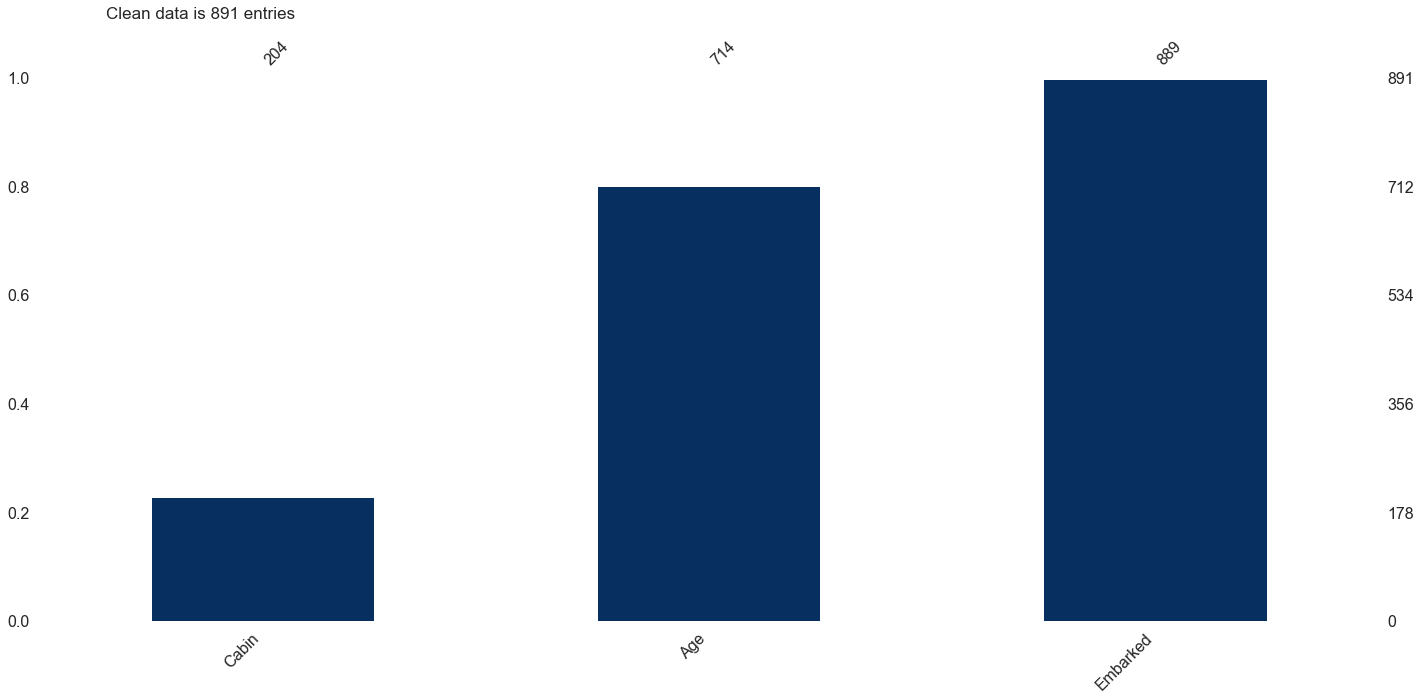

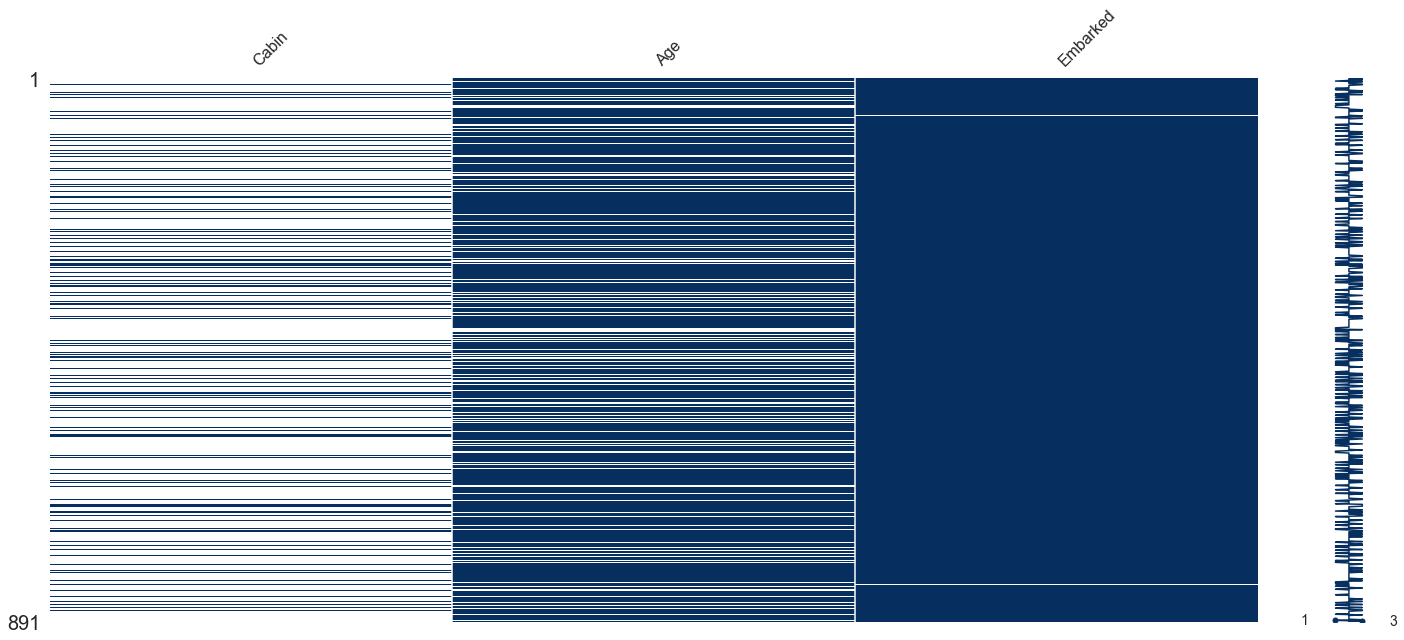

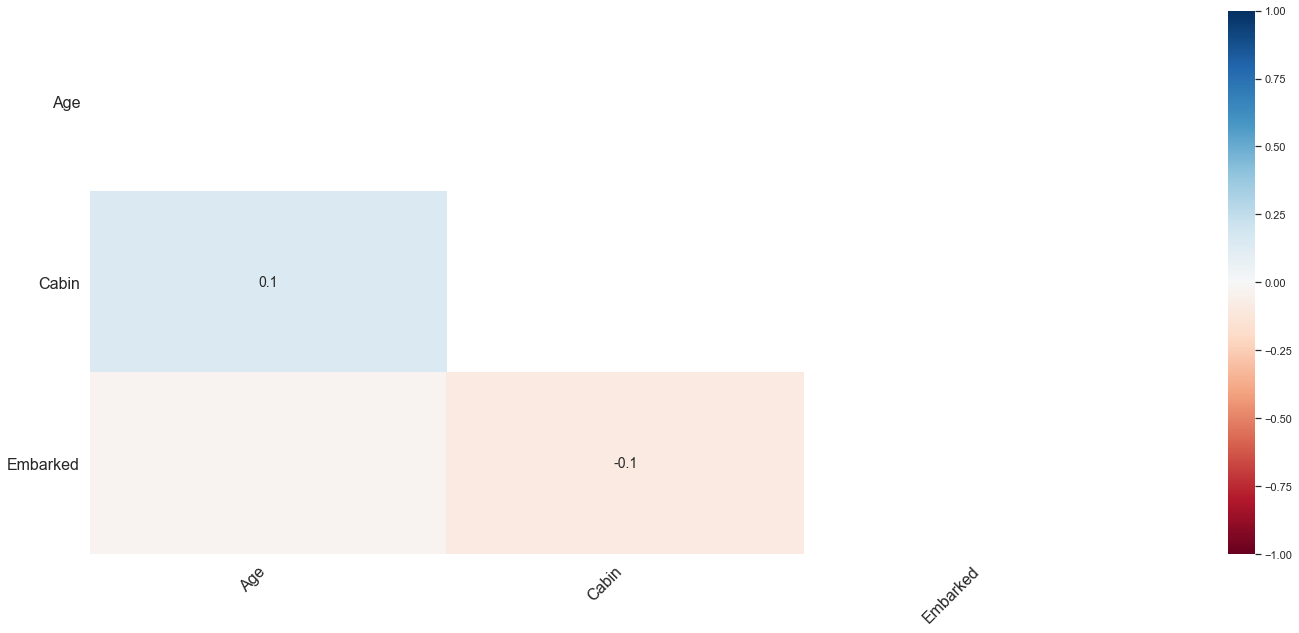

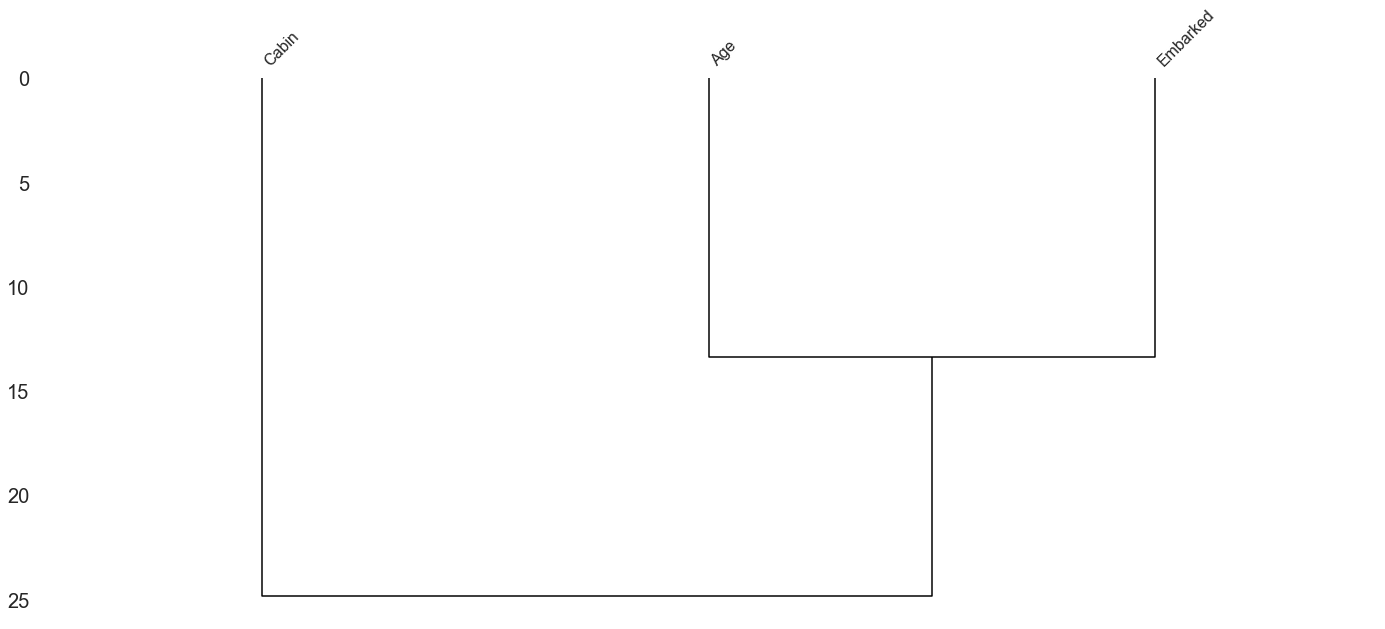

In [68]:
null_analysis = NullAnalysis(df_features,
                             project_sub_dir=inspect_data_project_dir,
                             notebook_mode=notebook_mode)

null_analysis.perform_analysis(df,
                               dataset_name="Full " + dataset_name,
                               null_features_only=True,
                               display_visuals=True,
                               display_print=False,
                               dataframe_snapshot=True)

In [69]:
missing_table = missing_values_table(df)
display(missing_table)
nan_features = missing_table[missing_table["% of Total Values"] > 15].index.to_list()
nan_features

,Missing Values,% of Total Values
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2


['Cabin', 'Age']

In [70]:
null_analysis.feature_analysis_of_null_data(df,
                                            "Full " + dataset_name,
                                            target_features=["Sex","Age",df_features.target_feature()],
                                            display_visuals=False,
                                            display_print=False,
                                            save_file=True,
                                            suppress_runtime_errors=False,
                                            aggregate_target_feature=True,
                                            extra_tables=True,
                                            nan_features=nan_features)

Feature Analysis on data where Cabin = NaN
Feature Analysis on data where Age = NaN


In [71]:
del null_analysis

# Analyze data after binning

In [72]:
continuous_numerical_features = df_features.continuous_numerical_features()

In [73]:
data_encoder.apply_binning(df,
                           df_features,
                           continuous_numerical_features)

In [74]:
df

,Survived,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked
0,0,16.336+ ⟷ 32.252,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,3rd Class,male,NaN,Southampton
1,1,32.252+ ⟷ 48.168,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,1st Class,female,C,Cherbourg
2,1,16.336+ ⟷ 32.252,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,3rd Class,female,NaN,Southampton
3,1,32.252+ ⟷ 48.168,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,1st Class,female,C,Southampton
4,0,32.252+ ⟷ 48.168,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,3rd Class,male,NaN,Southampton
...,...,...,...,...,...,...,...,...,...
886,0,16.336+ ⟷ 32.252,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,2nd Class,male,NaN,Southampton
887,1,16.336+ ⟷ 32.252,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,1st Class,female,B,Southampton
888,0,NaN,0 ⟷ 1,=2,-0.512+ ⟷ 102.466,3rd Class,female,NaN,Southampton
889,1,16.336+ ⟷ 32.252,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,1st Class,male,C,Cherbourg


# Feature Analysis of feature data after binning

In [75]:
feature_analysis = FeatureAnalysis(df_features,
                                   project_sub_dir=inspect_data_project_dir)
feature_analysis.perform_analysis(df,
                                  dataset_name= "Full " + dataset_name,
                                  target_features=["Sex","Age",df_features.target_feature()],
                                  suppress_runtime_errors=True,
                                  display_print=False,
                                  display_visuals=False,
                                  dataframe_snapshot=False,
                                  selected_features=continuous_numerical_features,
                                  statistical_analysis_on_aggregates=False)

/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_

# Get entropy table

In [76]:
infile = open(feature_analysis.folder_path + "Full " + dataset_name + "/_Extras/Entropy Table.pkl",'rb')
entropy_table = pickle.load(infile)
infile.close()
entropy_table

,Entropy
Fare,0.252775
SibSp,0.374043
Parch,0.404167
Sex,0.648928
Survived,0.665912
Embarked,0.760292
Pclass,0.997662
Age,1.267849
Cabin,1.752776


In [77]:
del feature_analysis

# Null Analysis of data after binning

In [78]:
null_analysis = NullAnalysis(df_features,
                             project_sub_dir=inspect_data_project_dir,
                             notebook_mode=notebook_mode)

In [79]:
null_analysis.feature_analysis_of_null_data(df,
                                            "Full " + dataset_name,
                                            target_features=["Sex","Age",df_features.target_feature()],
                                            display_visuals=False,
                                            display_print=False,
                                            save_file=True,
                                            selected_features=continuous_numerical_features,
                                            suppress_runtime_errors=True,
                                            aggregate_target_feature=True,
                                            extra_tables=True,
                                            nan_features=nan_features,
                                            statistical_analysis_on_aggregates=False)

Feature Analysis on data where Cabin = NaN


/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_

Feature Analysis on data where Age = NaN


/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/ericcacciavillani/anaconda3/envs/eflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 10231 missing from current font.
  font.set_

In [80]:
del null_analysis

In [81]:
remove_unconnected_pipeline_segments()

# Playground env

In [82]:
import seaborn as sns

,Survived,Age,SibSp,Parch,Fare,Pclass,Sex,Cabin,Embarked
0,0,16.336+ ⟷ 32.252,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,3rd Class,male,NaN,Southampton
1,1,32.252+ ⟷ 48.168,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,1st Class,female,C,Cherbourg
2,1,16.336+ ⟷ 32.252,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,3rd Class,female,NaN,Southampton
3,1,32.252+ ⟷ 48.168,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,1st Class,female,C,Southampton
4,0,32.252+ ⟷ 48.168,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,3rd Class,male,NaN,Southampton
...,...,...,...,...,...,...,...,...,...
886,0,16.336+ ⟷ 32.252,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,2nd Class,male,NaN,Southampton
887,1,16.336+ ⟷ 32.252,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,1st Class,female,B,Southampton
888,0,NaN,0 ⟷ 1,=2,-0.512+ ⟷ 102.466,3rd Class,female,NaN,Southampton
889,1,16.336+ ⟷ 32.252,0 ⟷ 1,0 ⟷ 1,-0.512+ ⟷ 102.466,1st Class,male,C,Cherbourg


ValueError: could not convert string to float: '16.336+ ⟷ 32.252'

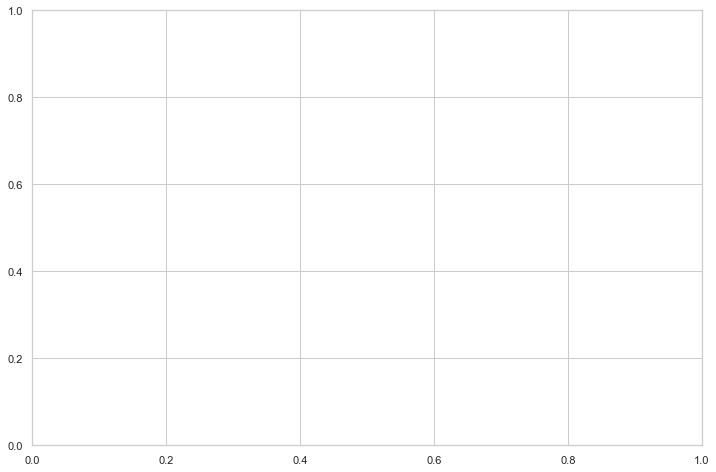

In [83]:
target_feature = df_features.target_feature()
i = 0
display(df)
colors = ["b", "g", "y", "black"]
plt.close()
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
for target_val in df["Survived"].dropna().value_counts().index:
    sns.distplot(df["Age"].dropna()[df["Survived"].dropna() == target_val],
                 color=colors[i])
    i += 1
plt.show()
plt.close()

# plt.figure(figsize=(12, 8))
# sns.pairplot(df[[feature_name for feature_name in df.columns if feature_name not in df_features.get_string_features()]], hue=f"{target_feature}", diag_kind='hist')

In [ ]:
x1 = np.random.normal(0, 0.8, 1000)
x2 = np.random.normal(-2, 1, 1000)
x3 = np.random.normal(3, 2, 1000)

kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)

sns.distplot(x1)
sns.distplot(x2)
sns.distplot(x3)

In [ ]:
from sklearn.preprocessing import StandardScaler, PowerTransformer, Normalizer, normalize, RobustScaler,QuantileTransformer

test_feature = "Fare"
pt = PowerTransformer()

# Scale data 
new_series = pt.fit_transform(df[[test_feature]]).flatten()

sns.distplot(new_series[~np.isnan(new_series)])

In [ ]:
# new_series = df[test_feature]
min_val = min(new_series)
max_val = max(new_series)
tmp_list = []
for val in new_series:
    tmp_list.append((val-min_val)/(max_val - min_val))

new_series = np.array([tmp_list])
sns.distplot(new_series[~np.isnan(new_series)])

In [ ]:
from eflow.utils.pandas_utils import descr_table

descr_table(df,
            test_feature,
            to_numeric=True)

In [ ]:
sns.distplot(df[test_feature].dropna())

In [ ]:
new_series = df[test_feature].dropna()
new_series = np.log(new_series + np.abs(min(new_series)) + 1)
sns.distplot(new_series)

In [ ]:
sns.distplot(normalize([df[test_feature].dropna()]).flatten())

In [ ]:
sns.distplot(df[test_feature])